## Boosting a decision stump

In this homework you will implement your own boosting module.

Brace yourselves! This is going to be a fun and challenging assignment.

Use SFrames to do some feature engineering.
Train a boosted ensemble of decision-trees (gradient boosted trees) on the lending club dataset.
Predict whether a loan will default along with prediction probabilities (on a validation set).
Evaluate the trained model and compare it with a baseline.
Find the most positive and negative loans using the learned model.
Explore how the number of trees influences classification performance.

In [32]:
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
from sklearn import linear_model

In [2]:
loans = pd.read_csv('/Users/kevinwang/Documents/Coursera/Machine Learning - Classification/Week4/lending-club-data.csv')  

/Users/kevinwang/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (19,47) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
loans['safe_loans'] = loans['bad_loans'].apply(lambda x : +1 if x==0 else -1)
loans = loans.drop('bad_loans', axis = 1)
#loans.fillna({'emp_length': 'N/A'}, inplace=True)
#loans.fillna({'term': 'N/A'}, inplace=True)
#loans.fillna({'home_ownership': 'N/A'}, inplace=True)
#loans.fillna({'emp_length': 'N/A'}, inplace=True)
#print(loans['emp_length'])
#print(loans['home_ownership'])

In [4]:
features = ['grade',              # grade of the loan
            'term',               # the term of the loan
            'home_ownership',     # home ownership status: own, mortgage or rent
            'emp_length',         # number of years of employment
           ]
#loans['safe_loans'] = loans['bad_loans'].apply(lambda x : +1 if x==0 else -1)
#loans[['grade_N/A', 'term_N/A', 'home_ownership_N/A', 'emp_length_N/A']]

target = 'safe_loans'
loans = loans[features + [target]]

In [229]:
#loans_hot = one_hot(loans[features])
#print(loans_hot.shape)

#print(loans_hot.columns)
#loans['grade_N/A']


#loans.drop(['grade_nan', 'term_nan', 'home_ownership_nan', 'emp_length_nan'], axis=1, inplace=True)

## Transform categorical data into binary features¶
Just like the previous assignment, we will implement binary decision trees. Since all of our features are currently categorical features, we want to turn them into binary features. Here is a reminder of what one-hot encoding is.

This technique of turning categorical variables into binary variables is called one-hot encoding. Using the software of your choice, perform one-hot encoding on the four features described above. You should now have 25 binary features.

For instance, the home_ownership feature represents the home ownership status of the loanee, which is either own, mortgage or rent. For example, if a data point has the feature

In [5]:
def one_hot(loans):
    return pd.get_dummies(loans, dummy_na=True)   # We don't need to identify Str variable, it will just transform 'object' var
    # dummy_na=True => When emp_length has 'NA', we do create emp_length_NA column
loans = one_hot(loans)
#print(loans_hot.columns)
loans.drop(['grade_nan', 'term_nan', 'home_ownership_nan', 'emp_length_nan'], axis=1, inplace=True)
print(loans.shape)

(122607, 25)


Load the JSON files into the lists train_idx and test_idx.
Perform train/validation split using train_idx and test_idx. In Pandas, for instance:

Note: There are many approaches for dealing with imbalanced data, including some where we modify the learning algorithm. These approaches are beyond the scope of this course, but some of them are reviewed in this paper. For this assignment, we use the simplest possible approach, where we subsample the overly represented class to get a more balanced dataset. In general, and especially when the data is highly imbalanced, we recommend using more advanced methods.

In [6]:
import json
with open('/Users/kevinwang/Documents/Coursera/Machine Learning - Classification/Week5/module-8-assignment-2-train-idx.json', 'r') as f: # Reads the list of most frequent words
    train_idx = json.load(f)
with open('/Users/kevinwang/Documents/Coursera/Machine Learning - Classification/Week5/module-8-assignment-2-test-idx.json', 'r') as f1: # Reads the list of most frequent words
    validation_idx = json.load(f1)

train_data = loans.iloc[train_idx]
validation_data = loans.iloc[validation_idx]
print(train_data.shape)        #(37224, 29)
print(validation_data.shape)   #(9284, 29)
train_loans_prop = sum(train_data['safe_loans'] == 1)/len(train_data)   #0.503653556845   Means data is very balanced
valid_loans_prop = sum(validation_data['safe_loans'] == 1)/len(validation_data)   #0.496553209823   Means data is very balanced
#print(train_loans_prop, valid_loans_prop)

y_train = train_data['safe_loans']
x_train = train_data.drop('safe_loans', axis=1)

y_valid = validation_data['safe_loans']
x_valid = validation_data.drop('safe_loans', axis=1)

#print(validation_data)

print(validation_data.iloc[:,10:])

(37224, 25)
(9284, 25)
        home_ownership_MORTGAGE  home_ownership_OTHER  home_ownership_OWN  \
24                            0                     0                   0   
41                            1                     0                   0   
60                            0                     0                   0   
93                            0                     0                   0   
132                           0                     0                   0   
...                         ...                   ...                 ...   
122390                        1                     0                   0   
122419                        0                     0                   0   
122445                        0                     0                   0   
122461                        0                     0                   0   
122480                        0                     0                   0   

        home_ownership_RENT  emp_length_1 year  emp_

## Weighted decision trees  (Not Adaboost)


Let's modify our decision tree code from Module 5 to support weighting of individual data points.

Weighted error definition

Consider a model with N data points with:

Predictions y^1,…,y^n;
Target y1,…,yn;
Data point weights α1,…,αn

Write a function to compute weight of mistakes


Write a function that calculates the weight of mistakes for making the "weighted-majority" predictions for a dataset. The function accepts two inputs:

labels_in_node: y1,…,yn
data_weights: Data point weights α1,…,αn
We are interested in computing the (total) weight of mistakes, i.e.

This quantity is analogous to the number of mistakes, except that each mistake now carries different weight. It is related to the weighted error in the following way: 

The function intermediate_node_weighted_mistakes should first compute two weights:

weighted_mistakes_all_negative (WM−1): weight of mistakes when all predictions are y^i=−1 i.e. WM(α,−1)
weighted_mistakes_all_positive (WM+1): weight of mistakes when all predictions are y^i=+1 i.e. WM(α,+1)
where −1 and +1 are vectors where all values are -1 and +1 respectively.
Because all datas that come to a node, would all get the same prediction, either 1 or 0. 

the function intermediate_node_weighted_mistakes should return the lower of the two weights of mistakes, along with the class associated with that weight. The function should be analogous to the following Python function:

In [7]:
#For all data that comes down to this leaf, should we forecast y = 1 or -1 for this node, 
#and what is the average weighted error; We return (avg weighted error, forecast for this leaf)

def intermediate_node_weighted_mistakes(labels_in_node, data_weights):   
    # Sum the weights of all entries with label +1
    total_weight_positive = sum(data_weights[labels_in_node == +1])
    
    # Weight of mistakes, if you predict -1's for every node, is equal to the sum above
    ### YOUR CODE HERE
    weighted_mistakes_all_negative = total_weight_positive
    
    # Sum the weights of all entries with label -1
    ### YOUR CODE HERE
    total_weight_negative = sum(data_weights[labels_in_node == -1])
    
    # Weight of mistakes, if you predict +1's for every node, is equal to the sum above
    ### YOUR CODE HERE
    weighted_mistakes_all_positive = total_weight_negative
    
    # Return the tuple (weight, class_label) representing the lower of the two weights
    #    class_label should be an integer of value +1 or -1.
    # If the two weights are identical, return (weighted_mistakes_all_positive,+1)
    ### YOUR CODE HERE
    if weighted_mistakes_all_negative < weighted_mistakes_all_positive:
        return (weighted_mistakes_all_negative,-1)
    else: 
        return (weighted_mistakes_all_positive,+1)
    

Recall that the classification error is defined as follows:

classification error = # mistakes / # all data points


Quiz Question: If we set the weights α=1 for all data points, how is the weight of mistakes WM(alpha, y_head) related to the classification error?

Answer: weight_mistake = Number of data N * classification error

## Function to pick best feature to split on

We continue modifying our decision tree code from the earlier assignment to incorporate weighting of individual data points. The next step is to pick the best feature to split on.

The best_splitting_feature function is similar to the one from the earlier assignment with two minor modifications:

The function best_splitting_feature should now accept an extra parameter data_weights to take account of weights of data points.
Instead of computing the number of mistakes in the left and right side of the split, we compute the weight of mistakes for both sides, add up the two weights, and divide it by the total weight of the data.
Your function should be analogous to the following Python function:

In [8]:
# If the data is identical in each feature, this function should return None

def best_splitting_feature(data, features, target, data_weights):
    
    # These variables will keep track of the best feature and the corresponding error
    best_feature = None
    best_error = float('+inf') 
    num_points = float(len(data))

    # Loop through each feature to consider splitting on that feature
    for feature in features:
        
        # The left split will have all data points where the feature value is 0
        # The right split will have all data points where the feature value is 1
        left_split = data[data[feature] == 0]    #x=0 go to left
        right_split = data[data[feature] == 1]   #x=1 go to right
        
        # Apply the same filtering to data_weights to create left_data_weights, right_data_weights
        ## YOUR CODE HERE
        left_data_weights = data_weights[data[feature] == 0]
        right_data_weights = data_weights[data[feature] == 1]
                    
        # DIFFERENT HERE
        # Calculate the weight of mistakes for left and right sides
        ## YOUR CODE HERE
        left_weighted_mistakes, left_class = intermediate_node_weighted_mistakes(left_split[target], left_data_weights)
        right_weighted_mistakes, right_class = intermediate_node_weighted_mistakes(right_split[target], right_data_weights)
        
        # DIFFERENT HERE
        # Compute weighted error by computing
        #  ( [weight of mistakes (left)] + [weight of mistakes (right)] ) / [total weight of all data points]
        ## YOUR CODE HERE
        error = (left_weighted_mistakes + right_weighted_mistakes)/ sum(data_weights)
        
        # If this is the best error we have found so far, store the feature and the error
        if error < best_error:
            best_feature = feature
            best_error = error
    
    # Return the best feature we found
    return best_feature

## Building the tree

With the above functions implemented correctly, we are now ready to build our decision tree. Recall from the previous assignments that each node in the decision tree is represented as a dictionary which contains the following keys:

{ 
   'is_leaf'            : True/False.
   'prediction'         : Prediction at the leaf node.
   'left'               : (dictionary corresponding to the left tree).
   'right'              : (dictionary corresponding to the right tree).
   'features_remaining' : List of features that are posible splits.
}

Let us start with a function that creates a leaf node given a set of target values. The create_leaf function should be analogous to the following cell:

In [9]:
def create_leaf(target_values, data_weights):
    
    # Create a leaf node
    leaf = {'splitting_feature' : None,
            'is_leaf': True}
    
    # Computed weight of mistakes.
    # Store the predicted class (1 or -1) in leaf['prediction']
    weighted_error, best_class = intermediate_node_weighted_mistakes(target_values, data_weights)
    leaf['prediction'] = best_class
    
    return leaf

Now write a function that learns a weighted decision tree recursively and implements 3 stopping conditions:

All data points in a node are from the same class.
No more features to split on.
Stop growing the tree when the tree depth reaches max_depth.
Since there are many steps involved, we provide you with a Python skeleton, along with explanatory comments.

In [10]:
def weighted_decision_tree_create(data, features, target, data_weights, current_depth = 1, max_depth = 10):
    remaining_features = features[:] # Make a copy of the features.
    target_values = data[target]
    print("--------------------------------------------------------------------")
    print("Subtree, depth = %s (%s data points)." % (current_depth, len(target_values)))
    
    # Stopping condition 1. Error is 0.
    if intermediate_node_weighted_mistakes(target_values, data_weights)[0] <= 1e-15:
        print("Stopping condition 1 reached.")               
        return create_leaf(target_values, data_weights)
    
    # Stopping condition 2. No more features.
    if remaining_features == []:
        print("Stopping condition 2 reached.")               
        return create_leaf(target_values, data_weights)    
    
    # Additional stopping condition (limit tree depth)
    if current_depth > max_depth:
        print("Reached maximum depth. Stopping for now.")
        return create_leaf(target_values, data_weights)
    
    # If all the datapoints are the same, splitting_feature will be None. Create a leaf
    splitting_feature = best_splitting_feature(data, features, target, data_weights)
    remaining_features.remove(splitting_feature)
        
    left_split = data[data[splitting_feature] == 0]
    right_split = data[data[splitting_feature] == 1]
    
    left_data_weights = data_weights[data[splitting_feature] == 0]
    right_data_weights = data_weights[data[splitting_feature] == 1]
    
    print("Split on feature %s. (%s, %s)" % (\
              splitting_feature, len(left_split), len(right_split)))
    
    # Create a leaf node if the split is "perfect"
    if len(left_split) == len(data):
        print("Creating leaf node.")
        return create_leaf(left_split[target], data_weights)
    if len(right_split) == len(data):
        print("Creating leaf node.")
        return create_leaf(right_split[target], data_weights)
    
    # Repeat (recurse) on left and right subtrees
    left_tree = weighted_decision_tree_create(
        left_split, remaining_features, target, left_data_weights, current_depth + 1, max_depth)
    right_tree = weighted_decision_tree_create(
        right_split, remaining_features, target, right_data_weights, current_depth + 1, max_depth)
    
    return {'is_leaf'          : False, 
            'prediction'       : None,
            'splitting_feature': splitting_feature,
            'left'             : left_tree, 
            'right'            : right_tree}

Finally, write a recursive function to count the nodes in your tree. The function should be analogous to

In [11]:
def count_nodes(tree):
    if tree['is_leaf']:
        return 1
    return 1 + count_nodes(tree['left']) + count_nodes(tree['right'])

## Making predictions with a weighted decision tree

To make a single prediction, we must start at the root and traverse down the decision tree in recursive fashion. Write a function classify that makes a single prediction. It should be analogous to the following:

In [12]:
def classify(tree, x, annotate = False):   
    # If the node is a leaf node.
    if tree['is_leaf']:
        if annotate: 
            print("At leaf, predicting %s" % tree['prediction'])
        return tree['prediction'] 
    else:
        # Split on feature.
        split_feature_value = x[tree['splitting_feature']]
        if annotate: 
            print("Split on %s = %s" % (tree['splitting_feature'], split_feature_value))
        if split_feature_value == 0:         # If the data point has x = 0, go left, if x = 1, go right.
            return classify(tree['left'], x, annotate)
        else:
            return classify(tree['right'], x, annotate)

## Evaluating the tree

Create a function called evaluate_classification_error. It takes in as input:

tree (as described above)
data (an data frame)
The function does not change because of adding data point weights. It is analogous to this Python function:

In [13]:
def evaluate_classification_error(tree, data):
    # Apply the classify(tree, x) to each row in your data (need to specify axis = 1, meaning apply func to each row)
    #prediction = data.apply(lambda x: classify(tree, x))
    prediction = data.apply(lambda x: classify(tree, x), axis=1)
    #data['prediction'] = [classify(tree,a) for a in data.to_dict(orient = 'records')]
    # Once you've made the predictions, calculate the classification error
    #print('prediction is in the following:\n' + str(prediction))
    print((prediction != data[target]).sum())
    print(float(len(data)))
    return round((prediction != data[target]).sum() / float(len(data)),2)

Example: Training a weighted decision tree

To build intuition on how weighted data points affect the tree being built, consider the following:

Suppose we only care about making good predictions for the first 10 and last 10 items in train_data, we assign weights:

1 to the last 10 items. 
1 to the first 10 items.
and 0 to the rest.  (The rest points not important)
It means all 20 points has same weight : 1

Let us fit a weighted decision tree with max_depth = 2. Then compute the classification error on the subset_20, i.e. the subset of data points whose weight is 1 (namely the first and last 10 data points).

In [14]:
example_data_weights = np.ones(10*1).tolist() + [0.]*(len(train_data) - 20) + np.ones(1*10).tolist()
example_data_weights = np.array(example_data_weights)
features = list(train_data.columns)
features.remove('safe_loans')

In [15]:
small_data_decision_tree_subset_20 = weighted_decision_tree_create(train_data, features, target,
                         example_data_weights, max_depth=2)

--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
Split on feature home_ownership_RENT. (20514, 16710)
--------------------------------------------------------------------
Subtree, depth = 2 (20514 data points).
Split on feature grade_F. (19613, 901)
--------------------------------------------------------------------
Subtree, depth = 3 (19613 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 3 (901 data points).
Stopping condition 1 reached.
--------------------------------------------------------------------
Subtree, depth = 2 (16710 data points).
Split on feature grade_D. (13315, 3395)
--------------------------------------------------------------------
Subtree, depth = 3 (13315 data points).
Stopping condition 1 reached.
--------------------------------------------------------------------
Subtree, depth = 3 (3395 data points).
Stoppin

Now, we will compute the classification error on the subset_20, i.e. the subset of data points whose weight is 1 (namely the first and last 10 data points).

In [16]:
subset20 = pd.concat([train_data.iloc[0:20,], train_data.iloc[-20:,]], axis=0)
evaluate_classification_error(small_data_decision_tree_subset_20, subset20)

8
40.0


0.2

In [17]:
print(small_data_decision_tree_subset_20['splitting_feature'])   #root_node
print(small_data_decision_tree_subset_20['left'])     #left_node 
print(small_data_decision_tree_subset_20['right'])    #right_node 

home_ownership_RENT
{'is_leaf': False, 'prediction': None, 'splitting_feature': 'grade_F', 'left': {'splitting_feature': None, 'is_leaf': True, 'prediction': 1}, 'right': {'splitting_feature': None, 'is_leaf': True, 'prediction': -1}}
{'is_leaf': False, 'prediction': None, 'splitting_feature': 'grade_D', 'left': {'splitting_feature': None, 'is_leaf': True, 'prediction': -1}, 'right': {'splitting_feature': None, 'is_leaf': True, 'prediction': 1}}


The tree forecast result is shown in the table below in 'safe loans forecast' field, The actual result is in the 'safe loans' field.

45, 58, 63, 87, 102, 118, 122501, 122544  are errored points; So 8 out of 40 points are wrong, so error rate = 0.2

The tree logic: 
1. If home_ownership_RENT = 0, then go left, and then if grade_F = 0 go left, predicting safe_loans = 1, means safe;
2. If home_ownership_RENT = 0, then go left, and then if grade_F = 1 go right, predicting safe_loans = -1, means not safe;
3. If home_ownership_RENT = 1, then go right, and then if grade_d = 0 go left, predicting safe_loans = -1, means not safe;
4. If home_ownership_RENT = 1, then go right, and then if grade_d = 1 go right, predicting safe_loans = 1, means safe;

In [18]:
prediction = subset20.apply(lambda x: classify(small_data_decision_tree_subset_20, x), axis=1)
prediction = pd.DataFrame(prediction,columns = ['safe loans forecast'])
#print('prediction is in the following:\n' + str(prediction))
sub = subset20[['home_ownership_RENT', 'grade_F', 'grade_D', 'safe_loans']]   
pd.concat([sub, prediction], axis=1)

,home_ownership_RENT,grade_F,grade_D,safe_loans,safe loans forecast
1,1,0,0,-1,-1
6,0,1,0,-1,-1
7,1,0,0,-1,-1
10,1,0,0,-1,-1
12,1,0,0,-1,-1
18,1,0,0,-1,-1
21,1,0,0,-1,-1
23,1,0,0,-1,-1
45,0,0,0,-1,1
48,1,0,0,-1,-1


The model small_data_decision_tree_subset_20 performs a lot better on subset_20 data than on whole train_data.

So, what does this mean?
1. The points with higher weights are the ones that are more important during the training process of the weighted decision tree.
2. The points with zero weights are basically ignored during training.

Quiz Question: Will you get the same model as small_data_decision_tree_subset_20 if you trained a decision tree with only 20 data points from the set of points in subset_20?

Answer: Yes

## Implementing your own Adaboost (on decision stumps)

Now that we have a weighted decision tree working, it takes only a bit of work to implement Adaboost. For the sake of simplicity, let us stick with decision tree stumps by training trees with max_depth=1.

Recall from the lecture the procedure for Adaboost:

Learn ft(x) with data weights αj
Compute coefficient w^t:
Re-compute weights αj:
Normalize weights αj:

Now write your own Adaboost function. The function accepts 4 parameters:

data: a data frame with binary features
features: list of feature names
target: name of target column
num_tree_stumps: number of tree stumps to train for the ensemble
The function should return the list of tree stumps, along with the list of corresponding tree stump weights.

It should be analogous to the following code skeleton:

In [19]:
from math import log
from math import exp

def adaboost_with_tree_stumps(data, features, target, num_tree_stumps):
    # start with unweighted data
    alpha = np.array([1.]*len(data))         #(number of data points *1)
    weights = []
    tree_stumps = []
    target_values = data[target]
    
    for t in range(num_tree_stumps):
        print('=====================================================')
        print('Adaboost Iteration %d' % t)
        print('=====================================================')       
        # Learn a weighted decision tree stump. Use max_depth=1
        tree_stump = weighted_decision_tree_create(data, features, target, data_weights=alpha, max_depth=1)
        tree_stumps.append(tree_stump)
        
        # Make predictions
        predictions = data.apply(lambda x: classify(tree_stump, x), axis=1)   # =>  number of data points *1
        
        # Produce a Boolean array indicating whether
        # each data point was correctly classified
        is_correct = predictions == target_values   # =>  number of data points *1
        is_wrong   = predictions != target_values   # =>  number of data points *1
        
        # Compute weighted error for the tree =>  1*1
        # YOUR CODE HERE
        weighted_error = sum(is_wrong * alpha) / sum(alpha)
        
        # Compute model coefficient using weighted error =>  1*1
        # YOUR CODE HERE
        weight = (1/2)*log((1-weighted_error)/weighted_error)  #=>  1*1
        weights.append(weight)                                 #=>  number of tree *1  
        
        # Adjust weights on data point   =>  number of data points *1
        adjustment = is_correct.apply(lambda is_correct : exp(-weight) if is_correct else exp(weight))
        
        # Scale alpha by multiplying by adjustment
        # Then normalize data points weights
        alpha = alpha * adjustment    # =>  number of data points *1
        alpha = alpha / sum(alpha)    # =>  number of data points *1
    
    return weights, tree_stumps

Reminders

Stump weights (w^) and data point weights (α) are two different concepts.
Stump weights (w^) tell you how important each stump is while making predictions with the entire boosted ensemble.
Data point weights (α) tell you how important each data point is while training a decision stump.

## Training a boosted ensemble of 10 stumps

Let us train an ensemble of 10 decision tree stumps with Adaboost. We run the adaboost_with_tree_stumps function with the following parameters:

train_data
features
target
num_tree_stumps = 10
Making predictions

Recall from the lecture that in order to make predictions, we use the following formula:

sign( w1f1 + w2f2 + w3f3)

Do the following things in a new function predict_adaboost:

1. Compute the predictions ft(x) using the t-th decision tree
2. Compute w^tft(x) by multiplying the stump_weights with the predictions ft(x) from the decision trees
3. Sum the weighted predictions over each stump in the ensemble.

In the end, your predict_adaboost should be analogous to this Python function:

In [20]:
def predict_adaboost(stump_weights, tree_stumps, data):
    scores = np.array([0.]*len(data))         #(number of data points *1)
    
    for i, tree_stump in enumerate(tree_stumps):
        predictions = data.apply(lambda x: classify(tree_stump, x), axis=1)
        
        # Accumulate predictions on scores array
        # YOUR CODE HERE
        scores = scores + stump_weights[i] * predictions              # (1*1)*(number of data points *1) 
     
    #print('forecasted results is: \n')
    return scores.apply(lambda score : +1 if score > 0 else -1)

In [27]:
stump_weights, tree_stumps = adaboost_with_tree_stumps(train_data, features, target, num_tree_stumps = 30)
prediction_adaboost = predict_adaboost(stump_weights, tree_stumps, train_data)
print(stump_weights)

Adaboost Iteration 0
--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
Split on feature term_ 36 months. (9223, 28001)
--------------------------------------------------------------------
Subtree, depth = 2 (9223 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (28001 data points).
Reached maximum depth. Stopping for now.
Adaboost Iteration 1
--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
Split on feature grade_A. (32094, 5130)
--------------------------------------------------------------------
Subtree, depth = 2 (32094 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (5130 data points).
Reached maximum depth. Stopping for now.
Adaboost Iteration 2
---------------------------------

Split on feature grade_E. (33815, 3409)
--------------------------------------------------------------------
Subtree, depth = 2 (33815 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (3409 data points).
Reached maximum depth. Stopping for now.
Adaboost Iteration 15
--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
Split on feature emp_length_4 years. (34593, 2631)
--------------------------------------------------------------------
Subtree, depth = 2 (34593 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (2631 data points).
Reached maximum depth. Stopping for now.
Adaboost Iteration 16
--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
Split on feature grade_F. (35512, 1712)
---------

Adaboost Iteration 29
--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
Split on feature grade_C. (27812, 9412)
--------------------------------------------------------------------
Subtree, depth = 2 (27812 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (9412 data points).
Reached maximum depth. Stopping for now.


In [40]:
#prediction_adaboost_df = pd.DataFrame(prediction_adaboost, columns = ['safe loans forecast'])
error = sum(train_data[target] != prediction_adaboost)/len(prediction_adaboost)
print(error)
print(stump_weights)

0.38182355469589513
[0.15802933659263743, 0.1768236329364191, 0.09311888971129693, 0.07288885525840554, 0.06706306914118143, 0.06456916961644449, 0.05456055779178564, 0.04351093673362621, 0.028988711500412448, 0.01933343817072769, 0.026277294071846483, 0.020995806817945405, 0.021503273392369168, 0.02039736140897628, 0.014491089745732887, 0.017530163149279653, 0.014515733928426056, 0.01597886285055662, 0.012353553814010553, 0.01183294211190397, 0.007807467994633988, 0.013156169046615923, 0.013011431459328949, 0.010941908086188444, 0.011573852882420714, 0.010288921027388927, 0.01176736935227864, 0.009898814931764964, 0.011458209167531293, 0.007065486661293114]


Use this function to answer the following question:

Quiz Question: Refer to the 10-component (stump) ensemble of tree stumps trained with Adaboost.  As each component (stump) is trained sequentially, are the component weights monotonically decreasing, monotonically increasing, or neither?

Answer: neither

Reminder: Stump weights w tell you how important each stump is while making predictions with the entire boosted ensemble.

## Performance plots
How does accuracy change with adding stumps to the ensemble?

We will now train an ensemble with:

train_data
features
target
num_tree_stumps = 30
Once we are done with this, we will then do the following:

Compute the classification error at the end of each iteration.
Plot a curve of classification error vs iteration.
First, let's train the model.

Computing training error at the end of each iteration

Let us compute the classification error on the train_data and see how it is reduced as trees are added.

For n = 1 to 30, do the following:

Make predictions on train_data using tree stumps 0, ..., n-1.
Compute classification error for the predictions
Record the classification error for that n.
The loop should be analogous to the following:

In [30]:
error_all = []
for n in range(1, 31):
    predictions = predict_adaboost(stump_weights[:n], tree_stumps[:n], train_data)
    error = sum(train_data[target] != predictions)/len(predictions)
    error_all.append(error)
    print("Iteration %s, training error = %s" % (n, error_all[n-1]))

Iteration 1, training error = 0.4216365785514722
Iteration 2, training error = 0.4334300451321728
Iteration 3, training error = 0.40003761014399314
Iteration 4, training error = 0.40003761014399314
Iteration 5, training error = 0.3847249086610789
Iteration 6, training error = 0.38461745110681284
Iteration 7, training error = 0.3827638082957232
Iteration 8, training error = 0.38461745110681284
Iteration 9, training error = 0.3827638082957232
Iteration 10, training error = 0.3814474532559639
Iteration 11, training error = 0.3814474532559639
Iteration 12, training error = 0.3814474532559639
Iteration 13, training error = 0.3814474532559639
Iteration 14, training error = 0.3814474532559639
Iteration 15, training error = 0.3814474532559639
Iteration 16, training error = 0.3814205888673974
Iteration 17, training error = 0.3814205888673974
Iteration 18, training error = 0.3816355039759295
Iteration 19, training error = 0.3816355039759295
Iteration 20, training error = 0.3816355039759295
Itera

Visualizing training error vs number of iterations

Let us generate the plot of classification error as a function of the number of iterations. Use the classification error values recorded.

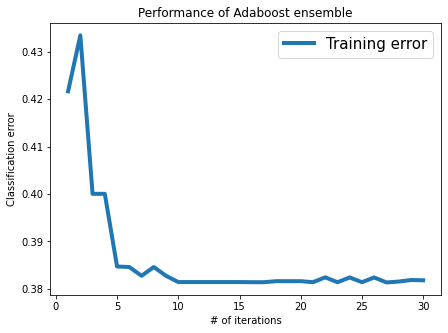

In [33]:
from matplotlib import pyplot as plt

plt.rcParams['figure.figsize'] = 7, 5
plt.plot(range(1,31), error_all, '-', linewidth=4.0, label='Training error')
plt.title('Performance of Adaboost ensemble')
plt.xlabel('# of iterations')
plt.ylabel('Classification error')
plt.legend(loc='best', prop={'size':15})
plt.rcParams.update({'font.size': 16})
plt.show()

Quiz Question: Which of the following best describes a general trend in accuracy as we add more and more components? Answer based on the 30 components learned so far.

(x) Training error goes down monotonically, i.e. the training error reduces with each iteration but never increases.
(v) Training error goes down in general, with some ups and downs in the middle.
(x) Training error goes up in general, with some ups and downs in the middle.
(x) Training error goes down in the beginning, achieves the best error, and then goes up sharply.
(x) None of the above

## Evaluation on the test data

Performing well on the training data is cheating, so lets make sure it works on the test_data as well. Here, we will compute the classification error on the test_data at the end of each iteration.

For n = 1 to 30, do the following:

Make predictions on test_data using tree stumps 0, ..., n-1.
Compute classification error for the predictions
Record the classification error for that n.
Visualize both the training and test errors

Let us plot the training & test error with the number of iterations.

In [34]:
prediction_adaboost_test = predict_adaboost(stump_weights, tree_stumps, validation_data)

In [35]:
test_error_all = []
for n in range(1, 31):
    predictions = predict_adaboost(stump_weights[:n], tree_stumps[:n], validation_data)
    error = sum(validation_data[target] != predictions)/len(predictions)
    test_error_all.append(error)
    print("Iteration %s, training error = %s" % (n, test_error_all[n-1]))

Iteration 1, training error = 0.4233089185695821
Iteration 2, training error = 0.42847910383455406
Iteration 3, training error = 0.3981042654028436
Iteration 4, training error = 0.3981042654028436
Iteration 5, training error = 0.3799009047824214
Iteration 6, training error = 0.38000861697544164
Iteration 7, training error = 0.3792546316242999
Iteration 8, training error = 0.38000861697544164
Iteration 9, training error = 0.3792546316242999
Iteration 10, training error = 0.37796208530805686
Iteration 11, training error = 0.37796208530805686
Iteration 12, training error = 0.37796208530805686
Iteration 13, training error = 0.37796208530805686
Iteration 14, training error = 0.37796208530805686
Iteration 15, training error = 0.37796208530805686
Iteration 16, training error = 0.37817750969409736
Iteration 17, training error = 0.37817750969409736
Iteration 18, training error = 0.3778543731150366
Iteration 19, training error = 0.3778543731150366
Iteration 20, training error = 0.377854373115036

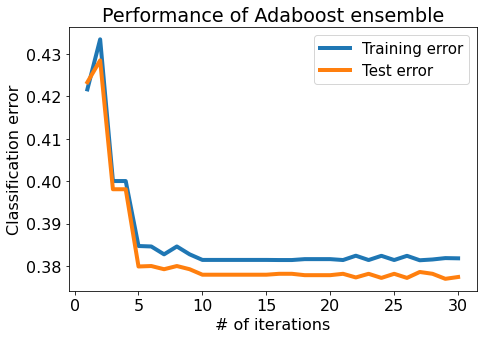

In [36]:
plt.rcParams['figure.figsize'] = 7, 5
plt.plot(range(1,31), error_all, '-', linewidth=4.0, label='Training error')
plt.plot(range(1,31), test_error_all, '-', linewidth=4.0, label='Test error')

plt.title('Performance of Adaboost ensemble')
plt.xlabel('# of iterations')
plt.ylabel('Classification error')
plt.rcParams.update({'font.size': 16})
plt.legend(loc='best', prop={'size':15})
plt.tight_layout()
plt.show()

Quiz Question: From this plot (with 30 trees), is there massive overfitting as the # of iterations increases?

Answer: no